In [1]:
# Import Required Libraries
import os
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
from sklearn.utils import class_weight
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.layers import Dense, Dropout, GlobalAveragePooling2D, Input
from tensorflow.keras.applications import EfficientNetV2S
from tensorflow.keras.applications.efficientnet_v2 import preprocess_input
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array
from tensorflow.keras.callbacks import ReduceLROnPlateau
from tensorflow.keras.optimizers import Adam
import tensorflow as tf
import gradio as gr

In [2]:
# Disable GPU so only CPU is used
os.environ["CUDA_VISIBLE_DEVICES"] = "-1"

# Use 8 threads instead of 12 (around 70–85% CPU load)
tf.config.threading.set_intra_op_parallelism_threads(8)
tf.config.threading.set_inter_op_parallelism_threads(2)

# Enable XLA for faster matrix math
tf.config.optimizer.set_jit(True)


In [3]:
# Set Paths
base_path = 'TrashType_Image_Dataset'  # Folder containing subfolders of classes

In [4]:
# Data Preprocessing
train_datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input,
    validation_split=0.2,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

train_gen = train_datagen.flow_from_directory(
    base_path,
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical',
    subset='training',
    shuffle=True
)

val_gen = train_datagen.flow_from_directory(
    base_path,
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical',
    subset='validation',
    shuffle=False
)

Found 2024 images belonging to 6 classes.
Found 503 images belonging to 6 classes.


In [5]:
class_weights = class_weight.compute_class_weight(
    class_weight='balanced',
    classes=np.unique(train_gen.classes),
    y=train_gen.classes
)
class_weights_dict = dict(enumerate(class_weights))

In [6]:
# 🔥 Define Focal Loss for class imbalance
def focal_loss(gamma=2., alpha=.25):
    def focal_loss_fixed(y_true, y_pred):
        epsilon = tf.keras.backend.epsilon()
        y_pred = tf.clip_by_value(y_pred, epsilon, 1. - epsilon)
        cross_entropy = -y_true * tf.math.log(y_pred)
        weight = alpha * tf.math.pow(1 - y_pred, gamma)
        loss = weight * cross_entropy
        return tf.reduce_sum(loss, axis=1)
    return focal_loss_fixed

In [7]:
# Build Model using EfficientNetV2S
base_model = EfficientNetV2S(
    weights='imagenet',
    include_top=False,
    input_tensor=Input(shape=(224, 224, 3))
)
# ✅ Fine-tune the deeper layers (last 60 layers)
for layer in base_model.layers[:-60]:
    layer.trainable = False
for layer in base_model.layers[-60:]:
    layer.trainable = True

x = GlobalAveragePooling2D()(base_model.output)
x = Dense(256, activation='relu')(x)
x = Dropout(0.5)(x)
x = Dense(128, activation='relu')(x)
x = Dropout(0.3)(x)
output = Dense(train_gen.num_classes, activation='softmax')(x)

In [8]:
# Compile Model with tuned focal loss
model = Model(inputs=base_model.input, outputs=output)
model.compile(
    optimizer=Adam(learning_rate=1e-4),
    loss=focal_loss(gamma=2.0, alpha=0.5),
    metrics=['accuracy']
)

In [9]:
# ⏱️ Early Stopping
from tensorflow.keras.callbacks import EarlyStopping
early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
lr_scheduler = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, verbose=1)


In [10]:
# 🏋️ Train Model
history = model.fit(
    train_gen,
    validation_data=val_gen,
    epochs=19,
    class_weight=class_weights_dict,
    callbacks=[early_stop, lr_scheduler]
)

C:\Users\anura\anaconda3\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/19
64/64 ━━━━━━━━━━━━━━━━━━━━ 260s 3s/step - accuracy: 0.2439 - loss: 0.6250 - val_accuracy: 0.6958 - val_loss: 0.3826 - learning_rate: 1.0000e-04
Epoch 2/19
64/64 ━━━━━━━━━━━━━━━━━━━━ 154s 2s/step - accuracy: 0.5639 - loss: 0.3677 - val_accuracy: 0.7773 - val_loss: 0.2217 - learning_rate: 1.0000e-04
Epoch 3/19
64/64 ━━━━━━━━━━━━━━━━━━━━ 147s 2s/step - accuracy: 0.7033 - loss: 0.2463 - val_accuracy: 0.8131 - val_loss: 0.1658 - learning_rate: 1.0000e-04
Epoch 4/19
64/64 ━━━━━━━━━━━━━━━━━━━━ 148s 2s/step - accuracy: 0.7720 - loss: 0.1750 - val_accuracy: 0.8171 - val_loss: 0.1457 - learning_rate: 1.0000e-04
Epoch 5/19
64/64 ━━━━━━━━━━━━━━━━━━━━ 146s 2s/step - accuracy: 0.7915 - loss: 0.1412 - val_accuracy: 0.8350 - val_loss: 0.1347 - learning_rate: 1.0000e-04
Epoch 6/19
64/64 ━━━━━━━━━━━━━━━━━━━━ 147s 2s/step - accuracy: 0.8334 - loss: 0.1125 - val_accuracy: 0.8529 - val_loss: 0.1324 - learning_rate: 1.0000e-04
Epoch 7/19
64/64 ━━━━━━━━━━━━━━━━━━━━ 148s 2s/step - accuracy: 0.8711 

In [11]:
# 💾 Save Model
model.save("efficientnetv2s_garbage_classifier_fixed.h5")
print("\n✅ Model saved as efficientnetv2s_garbage_classifier_fixed.h5")


✅ Model saved as efficientnetv2b0_garbage_classifier_fixed.h5


In [12]:
# 📊 Evaluation
val_preds = model.predict(val_gen)
y_pred = np.argmax(val_preds, axis=1)
y_true = val_gen.classes
labels = list(val_gen.class_indices.keys())

print("\n📋 Classification Report:")
print(classification_report(y_true, y_pred, target_names=labels))


16/16 ━━━━━━━━━━━━━━━━━━━━ 31s 2s/step

📋 Classification Report:
              precision    recall  f1-score   support

   cardboard       0.96      0.99      0.98        80
       glass       0.92      0.91      0.91       100
       metal       0.93      0.91      0.92        82
       paper       0.94      0.84      0.89       118
     plastic       0.86      0.78      0.82        96
       trash       0.43      0.78      0.55        27

    accuracy                           0.87       503
   macro avg       0.84      0.87      0.85       503
weighted avg       0.90      0.87      0.88       503



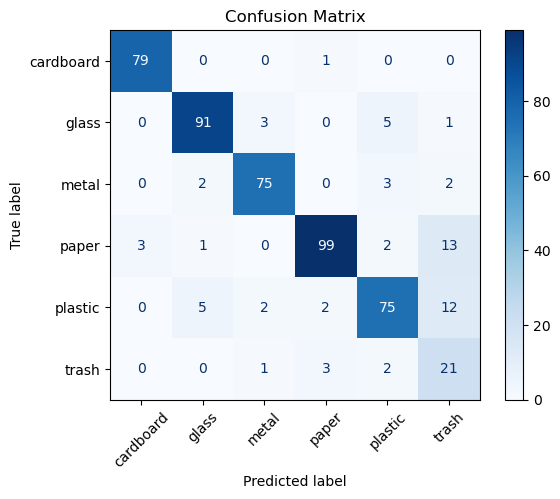

In [13]:
# 🔍 Confusion Matrix
cm = confusion_matrix(y_true, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
disp.plot(cmap=plt.cm.Blues, xticks_rotation=45)
plt.title("Confusion Matrix")
plt.show()

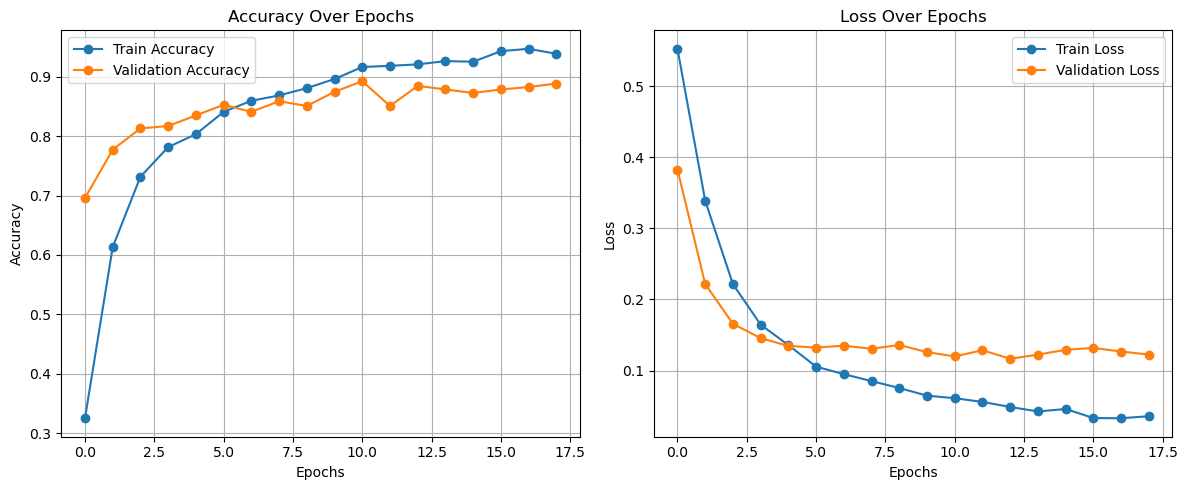

In [14]:
# 📈 Accuracy and Loss Graphs
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy', marker='o')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy', marker='o')
plt.title("Accuracy Over Epochs")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()
plt.grid(True)

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss', marker='o')
plt.plot(history.history['val_loss'], label='Validation Loss', marker='o')
plt.title("Loss Over Epochs")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [15]:
# Load trained model (make sure it's saved already)
from tensorflow.keras.models import load_model

# If you used custom loss (focal loss), provide dummy function
model = load_model("efficientnetv2s_garbage_classifier_fixed.h5", 
                   custom_objects={'focal_loss_fixed': lambda y_true, y_pred: y_pred})

print("✅ Model loaded successfully.")

# Class labels (same as during training)
class_labels = ['cardboard', 'glass', 'metal', 'paper', 'plastic', 'trash']
print("✅ Class labels loaded:", class_labels)

✅ Model loaded successfully.
✅ Class labels loaded: ['cardboard', 'glass', 'metal', 'paper', 'plastic', 'trash']


In [16]:
# 📷 Upload and Predict UI with Gradio
class_labels = class_labels = ['cardboard', 'glass', 'metal', 'paper', 'plastic', 'trash']
model = load_model("efficientnetv2s_garbage_classifier_fixed.h5", custom_objects={"focal_loss_fixed": focal_loss()})

def predict_material(img):
    try:
        img = img.resize((224, 224))
        img_array = img_to_array(img)
        img_array = np.expand_dims(img_array, axis=0)
        img_array = preprocess_input(img_array)
        prediction = model.predict(img_array)
        predicted_class = class_labels[np.argmax(prediction)]
        confidence = np.max(prediction) * 100
        return f"📦 Material: {predicted_class}\n🎯 Accuracy: {confidence:.2f}%"
    except Exception as e:
        return f"❌ Error: {str(e)}"

In [17]:
# Launch Gradio App in a New Browser Tab
from tensorflow.keras.preprocessing.image import img_to_array

import gradio as gr
gr.Interface(
    fn=predict_material,                    # Function to run for prediction
    inputs=gr.Image(type="pil"),            # Input: User uploads an image
    outputs="text",                         # Output: Text label of predicted class
    title="♻️ Garbage Classification", # Title shown on web interface
    description="Upload image of plastic, paper, glass etc. and get prediction."
).launch(share=False, inbrowser=True)       # inbrowser=True = open in new tab

* Running on local URL:  http://127.0.0.1:7865
* To create a public link, set `share=True` in `launch()`.
